<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">

Contact author(s): Andrés A. Plazas Malagón <br>
Contributions: Seth Digel, Aaron Roodman, Alex Broughton <br>
Last verified to run: 2025-3-06 <br>
LSST Science Pipelines version: Weekly 2024_50 <br>
Container Size: small <br>

In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np

import lsst.afw.cameraGeom.utils as camGeomUtils
from lsst.afw.cameraGeom import Detector, PIXELS, FOCAL_PLANE
from lsst.geom import Box2D, Point2D

# LSST Science Pipelines 
from lsst.daf.butler import Butler

# Set rubin publication plotting style
from lsst.utils.plotting import publication_plots, get_multiband_plot_colors

In [2]:
# Setup publication style
publication_plots.set_rubin_plotstyle()
colors = get_multiband_plot_colors()
bands = colors.keys()  # important to get the right order for plot legends
bands_dict = publication_plots.get_band_dicts()
%matplotlib inline

Set up Rubin matplotlib plot style.
This includes dicts for colors (bandpass colors for white background),
  colors_black (bandpass colors for black background), symbols, and line_styles,
  keyed on band (ugrizy).


In [3]:
# Mapping provided by Seth Digel via eTraveler, see CTN-001
raft_mapping_lsst = {
    "R00": "CRTM-0002", "R04": "CRTM-0004", "R40": "CRTM-0003", "R44": "CRTM-0005",
    "R01": "RTM-011", "R02": "RTM-013", "R03": "RTM-017", "R10": "RTM-023",
    "R11": "RTM-020", "R12": "RTM-009", "R13": "RTM-019", "R14": "RTM-006",
    "R20": "RTM-014", "R21": "RTM-025", "R22": "RTM-024", "R23": "RTM-005",
    "R24": "RTM-016", "R30": "RTM-012", "R31": "RTM-007", "R32": "RTM-015",
    "R33": "RTM-010", "R34": "RTM-008", "R41": "RTM-021", "R42": "RTM-018",
    "R43": "RTM-022"
}

ccd_serial_mapping_lsst = {
    0: "ITL-CCD-083", 1: "ITL-CCD-226", 2: "ITL-CCD-136", 3: "ITL-CCD-034",
    4: "ITL-CCD-072", 5: "ITL-CCD-095", 6: "ITL-CCD-164", 7: "ITL-CCD-227",
    8: "ITL-CCD-231", 9: "ITL-CCD-269", 10: "ITL-CCD-261", 11: "ITL-CCD-205",
    12: "ITL-CCD-160", 13: "ITL-CCD-244", 14: "ITL-CCD-157", 15: "ITL-CCD-423",
    16: "ITL-CCD-318", 17: "ITL-CCD-376", 18: "ITL-CCD-342", 19: "ITL-CCD-210",
    20: "ITL-CCD-467", 21: "ITL-CCD-432", 22: "ITL-CCD-454", 23: "ITL-CCD-451",
    24: "ITL-CCD-088", 25: "ITL-CCD-461", 26: "ITL-CCD-458", 27: "ITL-CCD-466",
    28: "ITL-CCD-040", 29: "ITL-CCD-167", 30: "ITL-CCD-223", 31: "ITL-CCD-350",
    32: "ITL-CCD-438", 33: "ITL-CCD-377", 34: "ITL-CCD-446", 35: "ITL-CCD-207",
    36: "E2V-CCD-319", 37: "E2V-CCD-321", 38: "E2V-CCD-359", 39: "E2V-CCD-364",
    40: "E2V-CCD-357", 41: "E2V-CCD-363", 42: "E2V-CCD-350", 43: "E2V-CCD-365",
    44: "E2V-CCD-361", 45: "E2V-CCD-136", 46: "E2V-CCD-267", 47: "E2V-CCD-196",
    48: "E2V-CCD-244", 49: "E2V-CCD-269", 50: "E2V-CCD-270", 51: "E2V-CCD-284",
    52: "E2V-CCD-287", 53: "E2V-CCD-265", 54: "E2V-CCD-322", 55: "E2V-CCD-331",
    56: "E2V-CCD-334", 57: "E2V-CCD-349", 58: "E2V-CCD-340", 59: "E2V-CCD-186",
    60: "E2V-CCD-170", 61: "E2V-CCD-336", 62: "E2V-CCD-346", 63: "E2V-CCD-229",
    64: "E2V-CCD-225", 65: "E2V-CCD-141", 66: "E2V-CCD-221", 67: "E2V-CCD-131",
    68: "E2V-CCD-190", 69: "E2V-CCD-211", 70: "E2V-CCD-192", 71: "E2V-CCD-217",
    72: "ITL-CCD-307", 73: "ITL-CCD-325", 74: "ITL-CCD-427", 75: "ITL-CCD-361",
    76: "ITL-CCD-440", 77: "ITL-CCD-411", 78: "ITL-CCD-225", 79: "ITL-CCD-455",
    80: "ITL-CCD-407", 81: "E2V-CCD-395", 82: "E2V-CCD-367", 83: "E2V-CCD-384",
    84: "E2V-CCD-391", 85: "E2V-CCD-366", 86: "E2V-CCD-392", 87: "E2V-CCD-393",
    88: "E2V-CCD-402", 89: "E2V-CCD-300", 90: "E2V-CCD-369", 91: "E2V-CCD-372",
    92: "E2V-CCD-378", 93: "E2V-CCD-356", 94: "E2V-CCD-382", 95: "E2V-CCD-383",
    96: "E2V-CCD-388", 97: "E2V-CCD-360", 98: "E2V-CCD-370", 99: "E2V-CCD-220",
    100: "E2V-CCD-239", 101: "E2V-CCD-154", 102: "E2V-CCD-165", 103: "E2V-CCD-130",
    104: "E2V-CCD-153", 105: "E2V-CCD-163", 106: "E2V-CCD-216", 107: "E2V-CCD-252",
    108: "E2V-CCD-140", 109: "E2V-CCD-314", 110: "E2V-CCD-302", 111: "E2V-CCD-298",
    112: "E2V-CCD-305", 113: "E2V-CCD-318", 114: "E2V-CCD-304", 115: "E2V-CCD-301",
    116: "E2V-CCD-385", 117: "E2V-CCD-237", 118: "E2V-CCD-281", 119: "E2V-CCD-234",
    120: "E2V-CCD-358", 121: "E2V-CCD-251", 122: "E2V-CCD-149", 123: "E2V-CCD-166",
    124: "E2V-CCD-214", 125: "E2V-CCD-228", 126: "E2V-CCD-260", 127: "E2V-CCD-182",
    128: "E2V-CCD-175", 129: "E2V-CCD-167", 130: "E2V-CCD-195", 131: "E2V-CCD-201",
    132: "E2V-CCD-222", 133: "E2V-CCD-213", 134: "E2V-CCD-177", 135: "E2V-CCD-293",
    136: "E2V-CCD-187", 137: "E2V-CCD-238", 138: "E2V-CCD-245", 139: "E2V-CCD-386",
    140: "E2V-CCD-247", 141: "E2V-CCD-261", 142: "E2V-CCD-286", 143: "E2V-CCD-129",
    144: "E2V-CCD-266", 145: "E2V-CCD-268", 146: "E2V-CCD-200", 147: "E2V-CCD-273",
    148: "E2V-CCD-179", 149: "E2V-CCD-263", 150: "E2V-CCD-226", 151: "E2V-CCD-264",
    152: "E2V-CCD-137", 153: "E2V-CCD-160", 154: "E2V-CCD-411", 155: "E2V-CCD-256",
    156: "E2V-CCD-253", 157: "E2V-CCD-194", 158: "E2V-CCD-231", 159: "E2V-CCD-224",
    160: "E2V-CCD-189", 161: "E2V-CCD-134", 162: "ITL-CCD-478", 163: "ITL-CCD-502", 164: "ITL-CCD-355",
    165: "ITL-CCD-508", 166: "ITL-CCD-470", 167: "ITL-CCD-358",
    168: "ITL-CCD-443", 169: "ITL-CCD-161", 170: "ITL-CCD-317",
    171: "ITL-CCD-138", 172: "ITL-CCD-140", 173: "ITL-CCD-327",
    174: "ITL-CCD-019", 175: "ITL-CCD-110", 176: "ITL-CCD-014",
    177: "ITL-CCD-509", 178: "ITL-CCD-510", 179: "ITL-CCD-486",
    180: "ITL-CCD-080", 181: "ITL-CCD-506", 182: "ITL-CCD-450",
    183: "ITL-CCD-396", 184: "ITL-CCD-203", 185: "ITL-CCD-476",
    186: "ITL-CCD-166", 187: "ITL-CCD-313", 188: "ITL-CCD-076", 189: "ITL-CCD-397", 190: "ITL-CCD-337",
    191: "ITL-CCD-029", 192: "ITL-CCD-023", 193: "ITL-CCD-351", 194: "ITL-CCD-366",
    195: "ITL-CCD-031", 196: "ITL-CCD-030", 197: "ITL-CCD-373", 198: "ITL-CCD-348",
    199: "ITL-CCD-028", 200: "ITL-CCD-027", 201: "ITL-CCD-332", 202: "ITL-CCD-388",
    203: "ITL-CCD-007", 204: "ITL-CCD-025"
}


raft_mapping_comcam = {"R22": "RTM-031"}
ccd_serial_mapping_comcam = {
    0: "ITL-3800C-229",
    1: "ITL-3800C-251",
    2: "ITL-3800C-215",
    3: "ITL-3800C-326",
    4: "ITL-3800C-283",
    5: "ITL-3800C-243",
    6: "ITL-3800C-319",
    7: "ITL-3800C-209",
    8: "ITL-3800C-206"
}

In [4]:
# Logic here, depending on type of plot to produce
camera_name = "ComCam" #Choose "ComCam" or "LSSTCam".
display_module_and_serial = False #False: fig1; True:fig2

In [5]:
if camera_name == "LSSTCam":
    from lsst.obs.lsst import LsstCam
    camera = LsstCam.getCamera()
    font_segment = 6
    font_det_label = 4
    central_det_id = 94
    #title_fontsize = 20
    #x_fontsize = 18
    #y_fontsize = 18
    #tick_labelsize = 14
    font_raft_label = 12
    raft_mapping = raft_mapping_lsst
    ccd_serial_mapping = ccd_serial_mapping_lsst
elif camera_name == "ComCam":
    from lsst.obs.lsst import LsstComCam
    camera = LsstComCam.getCamera()
    font_segment = 14
    font_det_label = 20
    central_det_id = 4
    title_fontsize = 20
    #x_fontsize = 18
    #y_fontsize = 18
    #tick_labelsize = 16
    font_raft_label = 22
    raft_mapping = raft_mapping_comcam
    ccd_serial_mapping = ccd_serial_mapping_comcam

## Code for producing the figures in CTN-001

In [6]:
# Define bad amplifier segments.
#Taken from Tables 8 and 9 of SITCOMTN-148, only for LSSTCam for now. 
non_functional_segs = {
    "dead": [
        "R30_S00_C10",
        "R01_S01_C00",
        "R03_S11_C00",
        "R04_SG0_C11"
    ],
    "hi_noise": [
        "R41_S21_C02",
        "R43_S20_C14",
        "R03_S01_C05",
        "R40_SG1_C10",
        "R44_SG0_C02"
    ]
}

In [7]:
###############################################################################
# Helper functions

def get_raft_and_sensor(detector):
    """
    Parse the detector name to extract raft and sensor names.
    For example, "R04_SW0" → raft "R04" and sensor "SW0".
    """
    detName = detector.getName()
    match = re.match(r'^(R\d{2})_([A-Z0-9]+)$', detName)
    if match:
        return match.group(1), match.group(2)
    else:
        parts = detName.split('_')
        if len(parts) >= 2:
            return parts[0], parts[1]
        return detName, None

def get_sensor_color(det):
    """
    Determine a color for a detector based on its physical type.
    Uses LSST’s detector information (e.g., ITL vs. e2v).
    """
    ptype = det.getPhysicalType()  # e.g., "ITL_WF", "ITL_SCIENCE", "e2v", etc.
    if ptype == "ITL":
        return "#D55E00"  # vermillion for ITL
    elif ptype == "E2V":
        return "#0072B2"  # blue for e2v
    elif ptype == "ITL_G":
        return "#CC79A7"  # purple for guider
    elif ptype == "ITL_WF":
        return "#009E73"  # green for wavefront (if not already caught above)
    else:
        return "#000000"

def get_focal_plane_bbox(detector):
    """
    Compute the bounding box of a detector (CCD) in focal-plane coordinates (mm).
    """
    corners = detector.getCorners(camGeomUtils.FOCAL_PLANE)
    xs = [pt.getX() for pt in corners]
    ys = [pt.getY() for pt in corners]
    return Box2D(Point2D(min(xs), min(ys)), Point2D(max(xs), max(ys)))

def plot_box(ax, box, edgecolor='black', linewidth=1, linestyle='-'):
    """
    Draw a rectangular patch defined by an lsst.geom.Box2D onto the given Axes.
    """
    min_pt = box.getMin()
    max_pt = box.getMax()
    width = max_pt.getX() - min_pt.getX()
    height = max_pt.getY() - min_pt.getY()
    rect = patches.Rectangle((min_pt.getX(), min_pt.getY()),
                             width, height,
                             edgecolor=edgecolor,
                             facecolor='none',
                             linewidth=linewidth,
                             linestyle=linestyle)
    ax.add_patch(rect)


In [8]:



###############################################################################
# Main plotting function

def plot_lsst_focal_plane(output_file_name):
    """
    Plot the LSSTCam focal plane using LSST stack functions.
    
    - Detectors are grouped by raft (extracted from detector names).
    - Each CCD is subdivided into its 16 amplifier regions.
    - Non-functional amplifiers (from the global non_functional amps list) are 
      filled with black and hatched.
    - Each CCD is labeled in the upper left with its sensor name
      (e.g. "S20" or "SW0")
      on the first line and its detector ID on the second.
    - A legend is added to explain CCD types.
    """
    # Group detectors by raft.
    raft_dict = {}
    for det in camera:
        raft, sensor = get_raft_and_sensor(det)
        raft_dict.setdefault(raft, []).append(det)
    
    # Initialize aggregated bounding boxes.
    itl_bbox = None
    e2v_bbox = None
    fp_bbox_total = None
    
    mpl.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Loop over each raft.
    for raft, detList in raft_dict.items():
        # Use the color of the first detector in the raft.
        raft_color = get_sensor_color(detList[0])
        # Compute the union bounding box for the raft.
        raft_bbox = None
        for det in detList:
            bbox = get_focal_plane_bbox(det)
            if raft_bbox is None:
                raft_bbox = bbox
            else:
                raft_bbox.include(bbox)
        if fp_bbox_total is None:
            fp_bbox_total = raft_bbox
        else:
            fp_bbox_total.include(raft_bbox)
        # Update aggregated ITL and e2v regions.
        for det in detList:
            ptype = det.getPhysicalType()
            bbox = get_focal_plane_bbox(det)
            if "ITL" in ptype:
                if itl_bbox is None:
                    itl_bbox = bbox
                else:
                    itl_bbox.include(bbox)
            elif "e2v" in ptype:
                if e2v_bbox is None:
                    e2v_bbox = bbox
                else:
                    e2v_bbox.include(bbox)
        # Draw the raft outline.
        plot_box(ax, raft_bbox, edgecolor=raft_color, linewidth=2,
                 linestyle='-')
        if raft == "R00":
            offset_x, offset_y = -25, -25
        elif raft == "R04":
            offset_x, offset_y = 25, -25
        elif raft == "R40":
            offset_x, offset_y = -25, 25
        elif raft == "R44":
            offset_x, offset_y = 25, 25
        else:
            offset_x, offset_y = 0, 0
        # Label the raft (centered) in black.
        raft_center = raft_bbox.getCenter()
        #print (raft, raft_center.getX() , raft_center.getY())

        if display_module_and_serial:
            raft_name = raft_mapping[raft]
        else:
            raft_name = raft
        if "CRTM" in raft_name: # For LSSTCam, with corner rafts
            #font_raft_label = 8
            ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, raft_name,
                color='black', fontsize=8, ha='center', va='center')
        else:
            ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, raft_name,
                color='black', fontsize=font_raft_label, ha='center', va='center')
        
        # Loop over each sensor (CCD) in the raft.
        for det in detList:
            sensor_bbox = get_focal_plane_bbox(det)
            det_color = get_sensor_color(det)
            plot_box(ax, sensor_bbox, edgecolor=det_color, linewidth=0.5, linestyle='-')
            # Label the sensor in the upper-left: show only the sensor name and ID.
            _, sensor_name = get_raft_and_sensor(det)
            label_x = sensor_bbox.getMin().getX() + 2
            label_y = sensor_bbox.getMax().getY() - 2

            det_id = det.getId()
            if display_module_and_serial:
                serial = ccd_serial_mapping[int(det_id)]
                det_id_label = serial.split("-")[-1]
            else:
                det_id_label = det_id
                
            label = f"{sensor_name} ({det_id_label})"

            # For labels in corner, use raft coordinate system to avoid overlaps.
            if det_id == 189:
                label = f"{sensor_name}\n({det_id_label})"
                offset_x = -5
                offset_y = -10
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 201:
                label = f"{sensor_name}\n({det_id_label})"
                offset_x = 6
                offset_y = 11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 198:
                label = f"{sensor_name}\n({det_id_label})"
                offset_x = -5
                offset_y = 11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 199:
                label = f"{sensor_name} ({det_id_label})"
                offset_x = 31
                offset_y = 0
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 200:
                label = f"{sensor_name} ({det_id_label})"
                offset_x = 8
                offset_y = 0
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 194:
                label = f"{sensor_name}\n({det_id_label})"
                offset_x = 6
                offset_y = -11
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=6, ha='center', va='center')
            elif det_id == 195:
                label = f"{sensor_name} ({det_id_label})"
                offset_x = -31
                offset_y = -1
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            elif det_id == 196:
                label = f"{sensor_name} ({det_id_label})"
                offset_x = -4
                offset_y = -1
                ax.text(raft_center.getX() + offset_x, raft_center.getY() + offset_y, label,
                color='black', fontsize=3.6, ha='center', va='center')
            else:
                label = f"{sensor_name} ({det_id_label})"
                ax.text(label_x, label_y, label,
                        color='black', fontsize=font_det_label, ha='left', va='top')
                
            # --- Subdivide the sensor into 16 amplifier regions ---
            
            transform = det.getTransform(PIXELS, FOCAL_PLANE)
            amps = list(det)
            if amps:
                # Determine pixel size from the first amplifier.
                amp_bbox0 = amps[0].getBBox()
                dx = amp_bbox0.getWidth()
                dy = amp_bbox0.getHeight()
                # Loop over amplifiers; assume names like "C00", "C01", etc.
                for amp in det:
                    # use BBox of the Amp to get the corners
                    bbox = amp.getBBox()
                    llcorner = bbox.getCorners()[0]
                    urcorner = bbox.getCorners()[2]
                    
                    p0 = transform.applyForward(Point2D(llcorner.getX(),llcorner.getY()))
                    p1 = transform.applyForward(Point2D(urcorner.getX(),urcorner.getY()))
                    
                    # Construct full amplifier ID as "DetectorName_ampName"
                    full_amp_id = f"{det.getName()}_{amp.getName()}"

                    if full_amp_id in non_functional_segs["dead"]:
                        facecolor = 'black'
                        hatch = None
                    elif full_amp_id in non_functional_segs["hi_noise"]:
                        facecolor = 'gray'
                        hatch = '///'
                    else:
                        facecolor = 'none'
                        hatch = None
                    
                    rect = patches.Rectangle((p0.getX(), p0.getY()),
                                             p1.getX() - p0.getX(),
                                             p1.getY() - p0.getY(),
                                             edgecolor=det_color,
                                             facecolor=facecolor,
                                             linewidth=0.4,
                                             linestyle='-',
                                             hatch=hatch)


                    # Add amp names
                    # Skip labeling amps if raft=R22, sensor=S11 (ID=94).
                    if not (raft == 'R22' and sensor_name == "S11"
                            and det_id == central_det_id):
                        # Only label amps in the central raft (R22) and corner rafts
                        if raft == "R22" or raft in ["R00", "R04", "R40", "R44"]:
                            rotation=90
                            amp_name_pos_x = p0.getX() + (p1.getX() - p0.getX())/2. - 0.75
                            amp_name_pos_y = p0.getY() + (p1.getY() - p0.getY())/2.
                            if det.getName() in ["R00_SG0", "R04_SW0", "R04_SW1", \
                                                 "R04_SG1", "R40_SW0", "R40_SW1", \
                                                 "R40_SG1", "R44_SG0"]:
                                rotation=0
                                amp_name_pos_x -= 2.25
                                amp_name_pos_y += 1.25
                                   
                            ax.text(amp_name_pos_x,amp_name_pos_y, 
                                    amp.getName(), color=det_color, 
                                    # fontsize=font_segment, 
                                    ha='left', va='top', 
                                    rotation=rotation)
                    ax.add_patch(rect)
                
    
    # Adjust plot limits.
    if fp_bbox_total is not None:
        margin = 10.0  # mm
        min_pt = fp_bbox_total.getMin()
        max_pt = fp_bbox_total.getMax()
        ax.set_xlim(min_pt.getX() - margin, max_pt.getX() + margin)
        ax.set_ylim(min_pt.getY() - margin, max_pt.getY() + margin)

    # Publication-quality axis labels and ticks.
    if display_module_and_serial:
        file_name = f"../figures/{camera_name}_focal_plane_with_serial.png"
        fig_title = f"../figures/{camera_name} Focal Plane by Raft and Sensor Serial Numbers"
    else:
        file_name = f"{camera_name}_focal_plane.png"
        fig_title = f"{camera_name} Focal Plane by Raft, Sensor, and Amplifier"

    # ax.set_title(fig_title, fontsize=title_fontsize)
    ax.set_xlabel("Focal Plane X (mm)", #fontsize=x_fontsize
                 )
    ax.set_ylabel("Focal Plane Y (mm)", #fontsize=y_fontsize
                 )
    # ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)
    ax.set_aspect('equal', 'box')
    ax.grid(False)
    
    # Create a legend.
    import matplotlib.patches as mpatches
    if camera_name == "LSSTCam":
        legend_handles = [
            mpatches.Patch(color="#D55E00", label="ITL"),
            mpatches.Patch(color="#0072B2", label="e2v"),
            mpatches.Patch(color="#CC79A7", label="Guider"),
            mpatches.Patch(color="#009E73", label="Wavefront"),
            mpatches.Patch(color='black', label="Dead segment"),
            mpatches.Patch(facecolor='gray', hatch="///",
                           label="High noise segment")
        ]
        ax.legend(handles=legend_handles, loc='upper right', 
              #fontsize=6.0,
                  ncol=2)
    else:
        legend_handles = [
            mpatches.Patch(color="#D55E00", label="ITL"),
        ]
        #ax.legend(handles=legend_handles, loc='upper right', 
         #     fontsize=18.0, ncol=1)
        
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

# To use, simply call:
# plot_lsst_focal_plane()


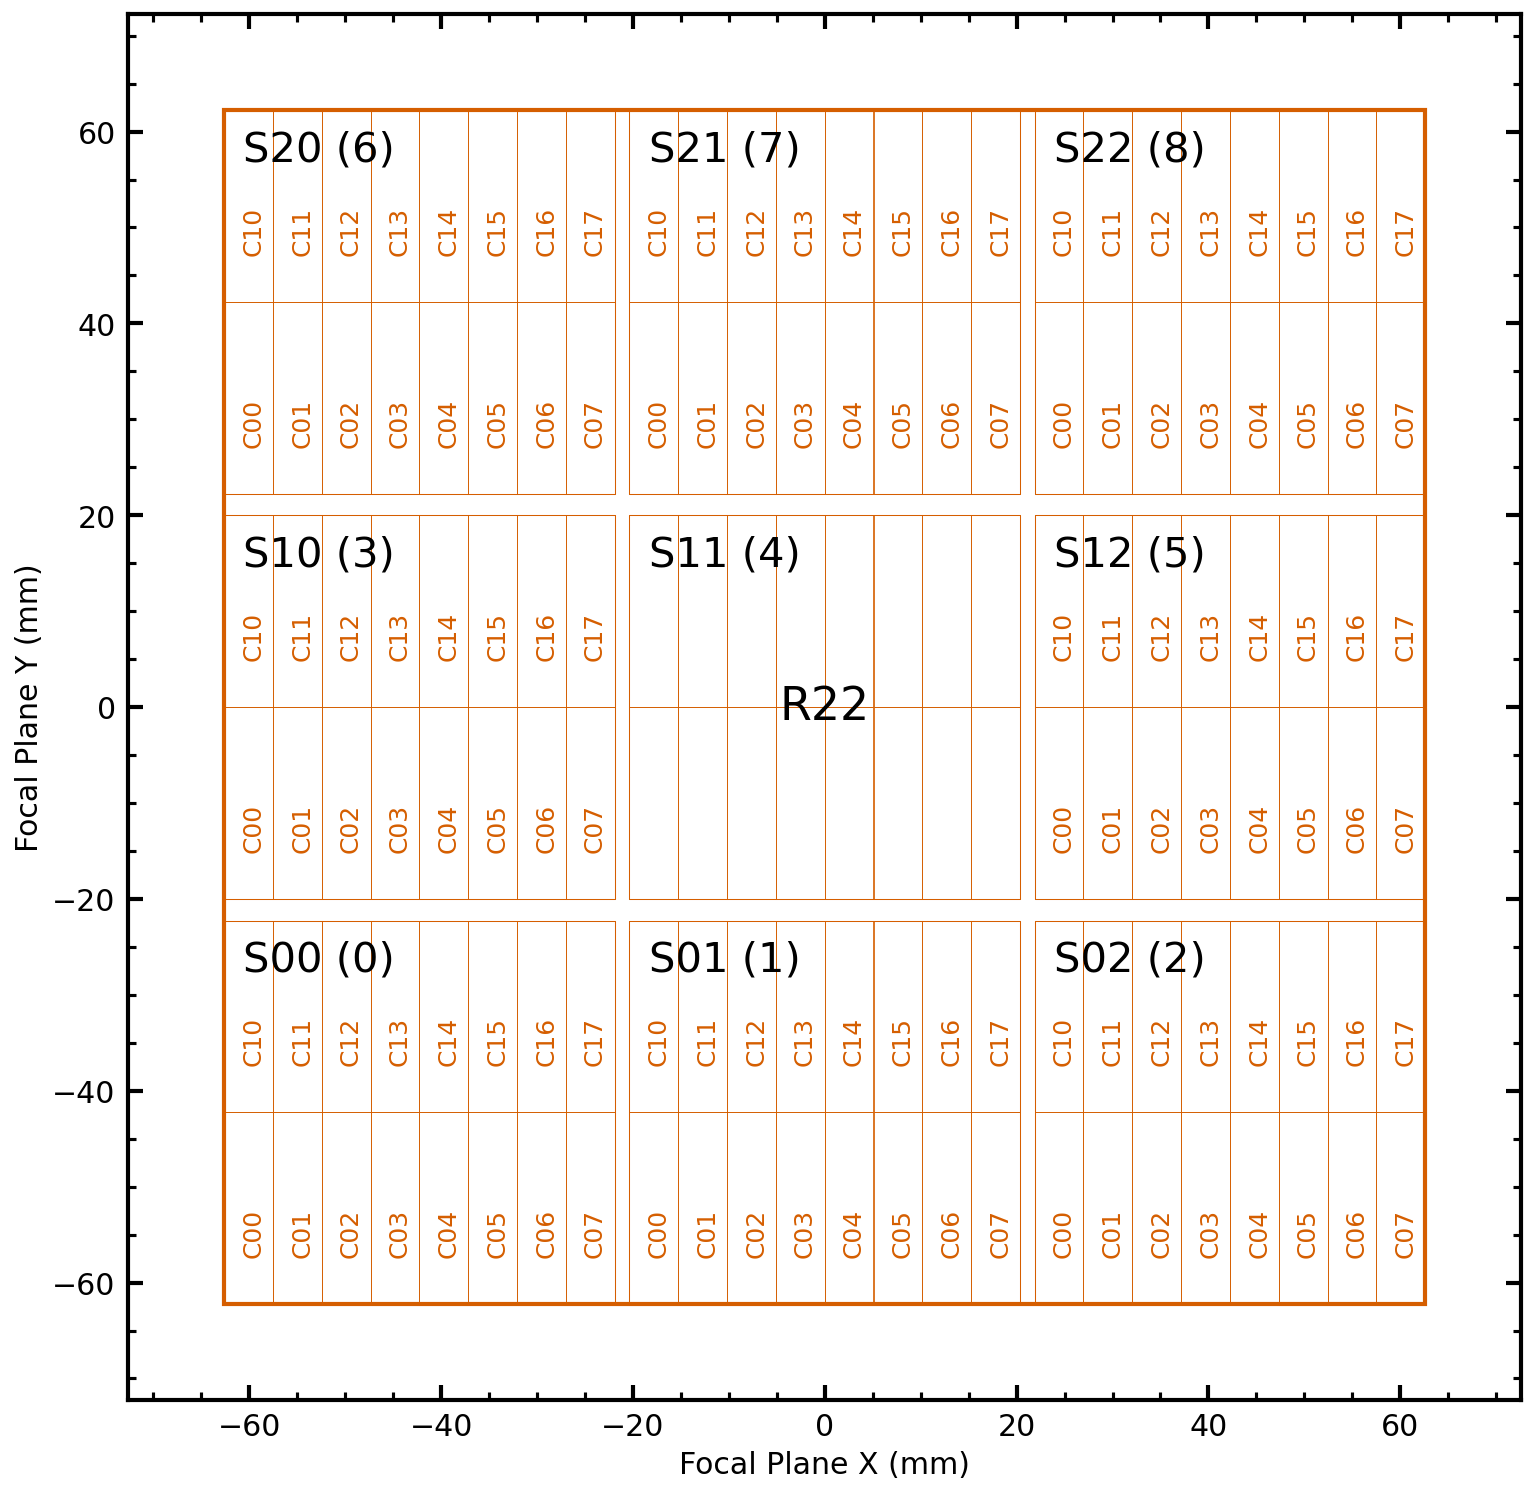

In [9]:
output_file_path = '../figures/ComCam_focal_plane.png'
plot_lsst_focal_plane(output_file_path)

In [10]:
raft_dict = {}
for det in camera:
    raft, sensor = get_raft_and_sensor(det)
    raft_dict.setdefault(raft, []).append(det)

In [11]:
raft_dict

{'R22': [<lsst.afw.cameraGeom.Detector at 0x7f46e3e5a770>,
  <lsst.afw.cameraGeom.Detector at 0x7f46e3d74270>]}